In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gp
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
import xgboost
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
ds = pd.read_csv('happiness_score_dataset.csv')
ds.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


### EDA

In [3]:
ds.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1

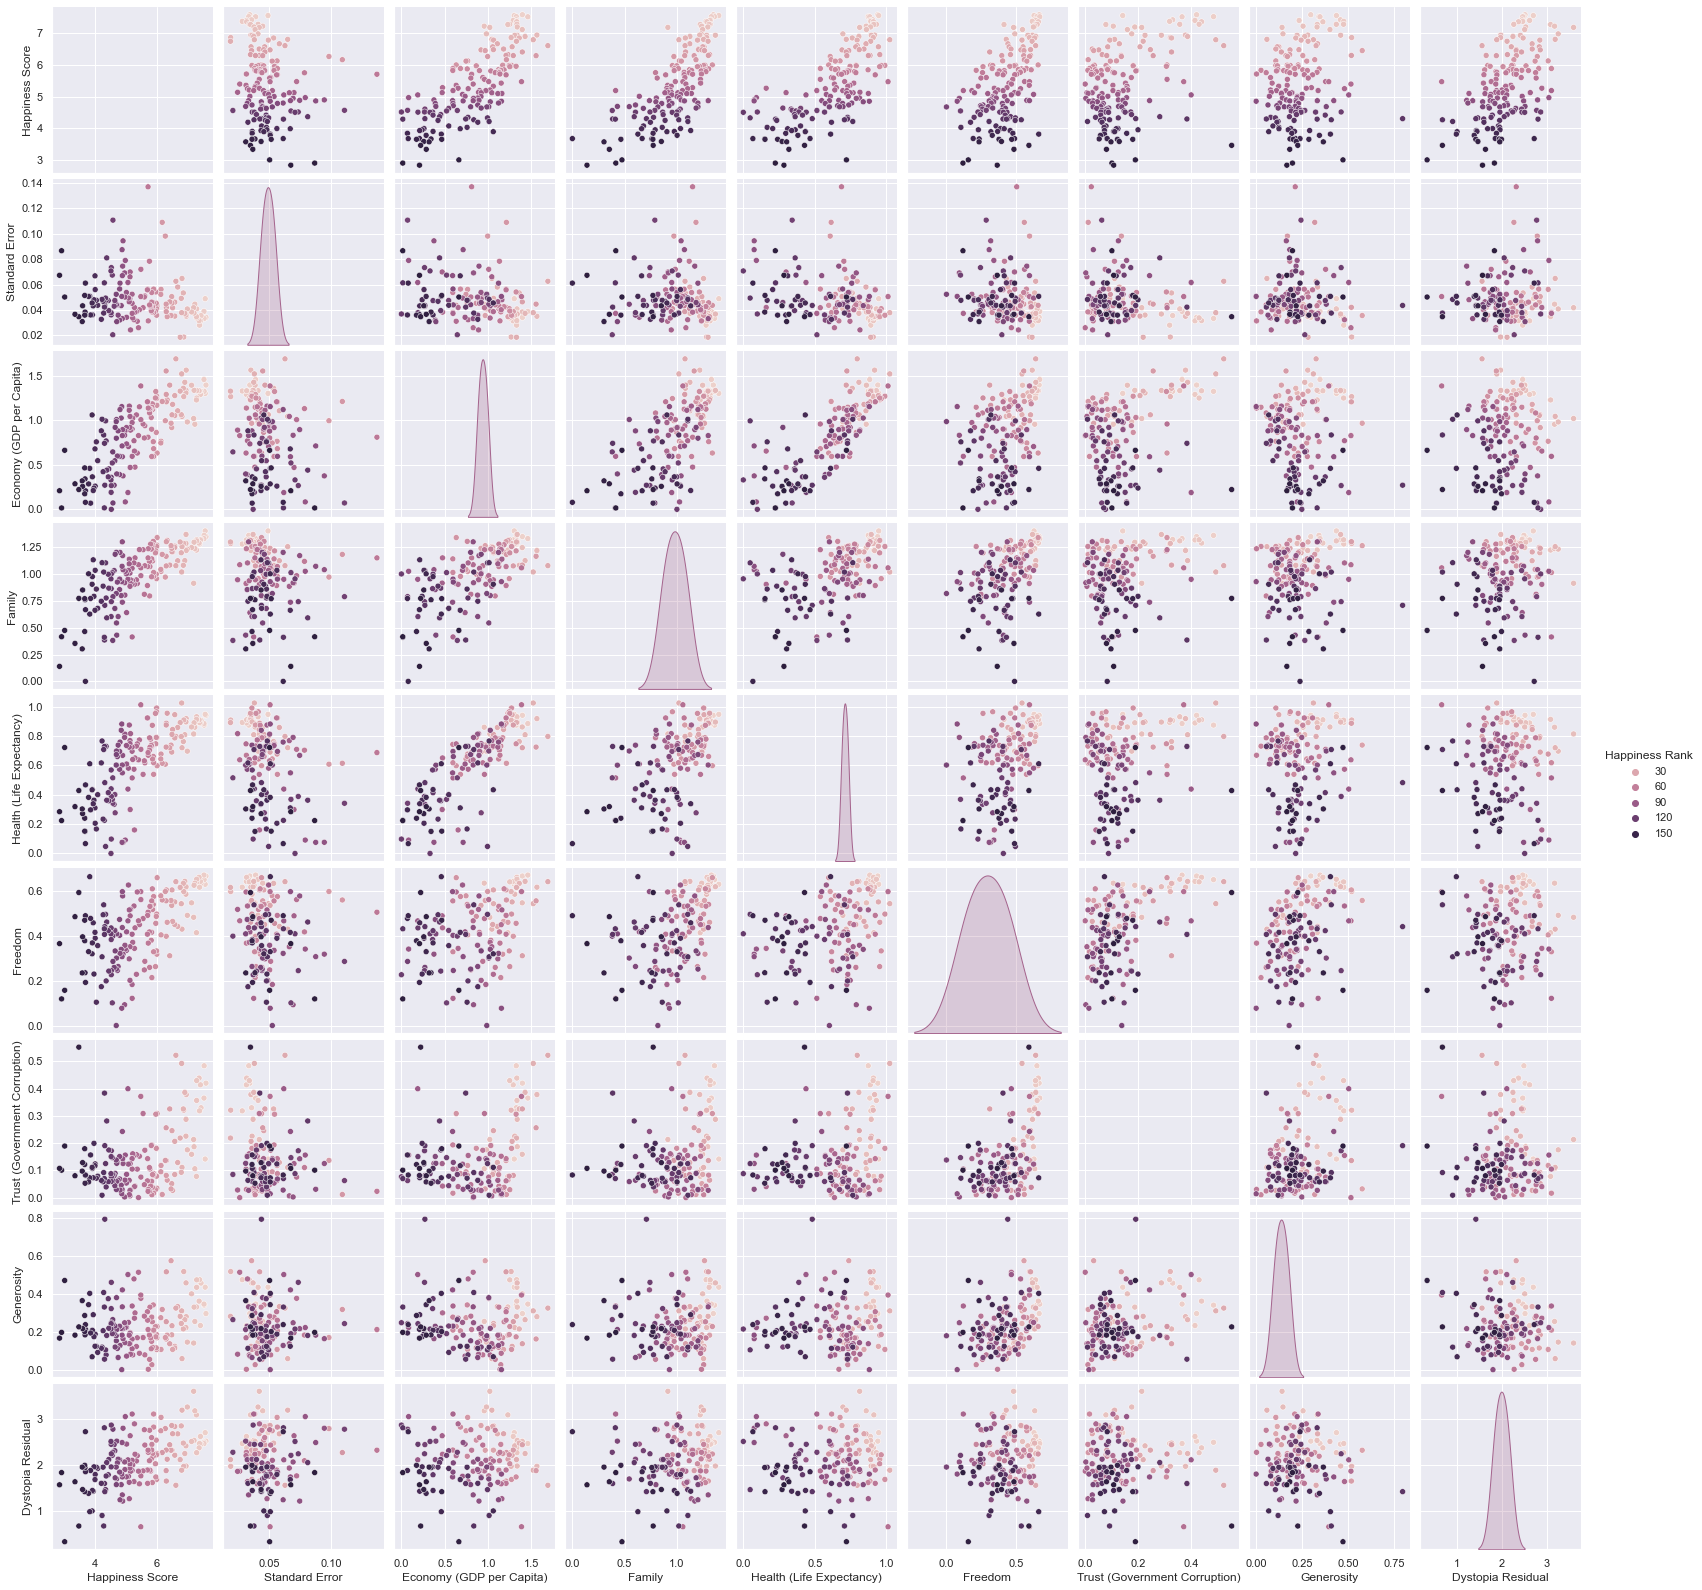

In [5]:
sb.pairplot(ds.select_dtypes(include=['float64','int64']), hue = 'Happiness Rank')
plt.show()

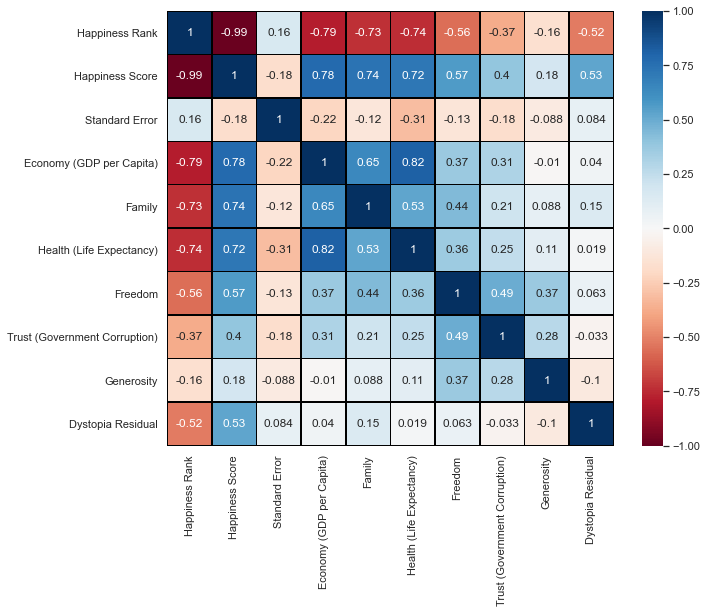

In [6]:
plt.figure(figsize = (10,8))
sb.heatmap(ds.select_dtypes(include=['float64','int64']).corr(), cmap = 'RdBu', vmin = -1, vmax = 1,
                           center = 0, linewidth = 0.5, linecolor = 'black', annot = True)
plt.show()

According to above plots, we can see that happiness score depends or is strongly correlated to Health(Life Expectancy), family, and and Economy(GDP per Capita) of the country.
Also, happiness score is not very much depended on other social aspect like Freedom, Trust(Government Corruption), Generosity, etc.

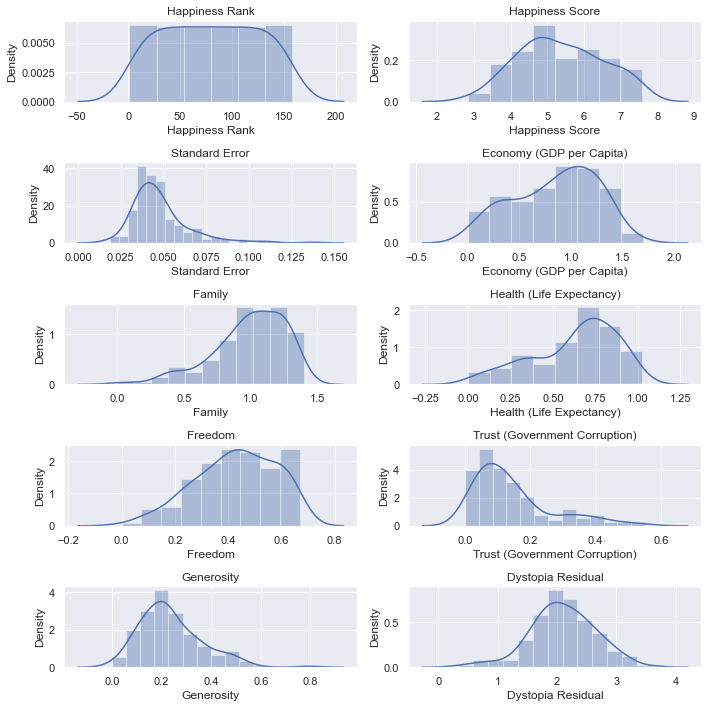

In [7]:
for i,col in enumerate(ds.columns[2:]):
    plt.subplot(5,2 ,i+1)
    sb.distplot(ds[col])
    plt.title(col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

From above plot some numeric data are having some skewness, so we shall transform them before modelling.

In [8]:
ds.groupby('Region')['Happiness Score'].mean()

Region
Australia and New Zealand          7.285000
Central and Eastern Europe         5.332931
Eastern Asia                       5.626167
Latin America and Caribbean        6.144682
Middle East and Northern Africa    5.406900
North America                      7.273000
Southeastern Asia                  5.317444
Southern Asia                      4.580857
Sub-Saharan Africa                 4.202800
Western Europe                     6.689619
Name: Happiness Score, dtype: float64

In [9]:
ds

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
...,...,...,...,...,...,...,...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,3.465,0.03464,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,0.67042
154,Benin,Sub-Saharan Africa,155,3.340,0.03656,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,1.63328
155,Syria,Middle East and Northern Africa,156,3.006,0.05015,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858
156,Burundi,Sub-Saharan Africa,157,2.905,0.08658,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302


In [10]:
top_10_country = ds.groupby(['Country'])['Happiness Score'].sum().sort_values(ascending = False).head(10)

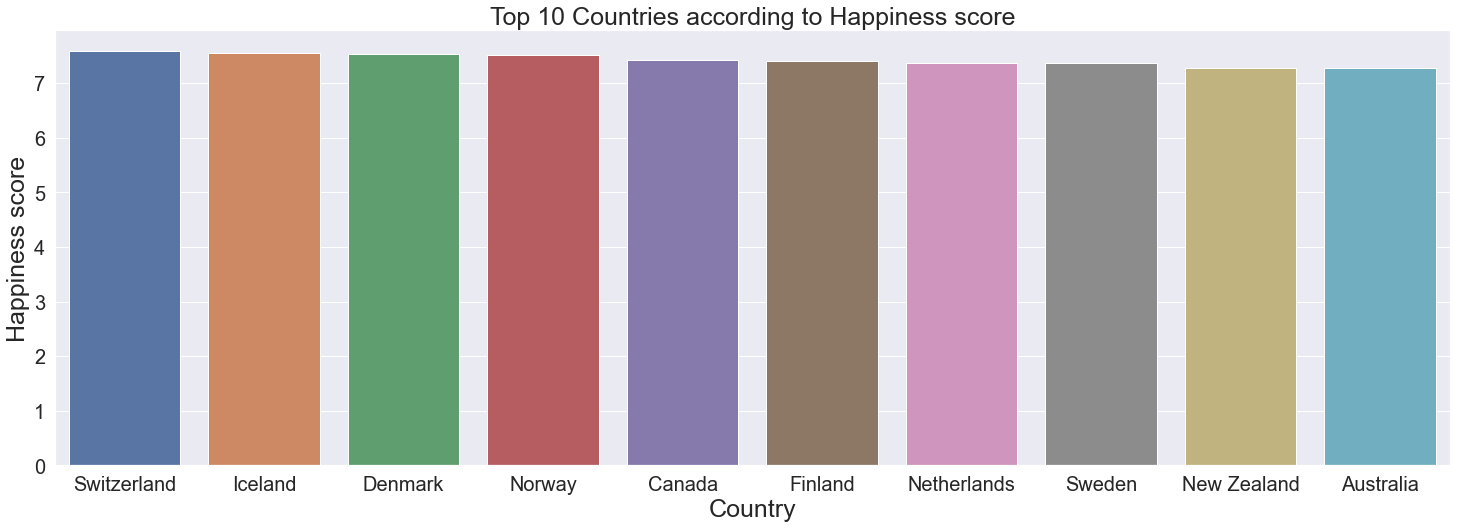

In [11]:
plt.figure(figsize = (25,8))
sb.barplot(x = top_10_country.index, y = top_10_country)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Happiness score', fontsize =  25)
plt.xlabel('Country' , fontsize = 25)
plt.title('Top 10 Countries according to Happiness score', fontsize = 25 )
plt.show()

In [12]:
last_10_country = ds.groupby(['Country'])['Happiness Score'].sum().sort_values(ascending = False).tail(10)

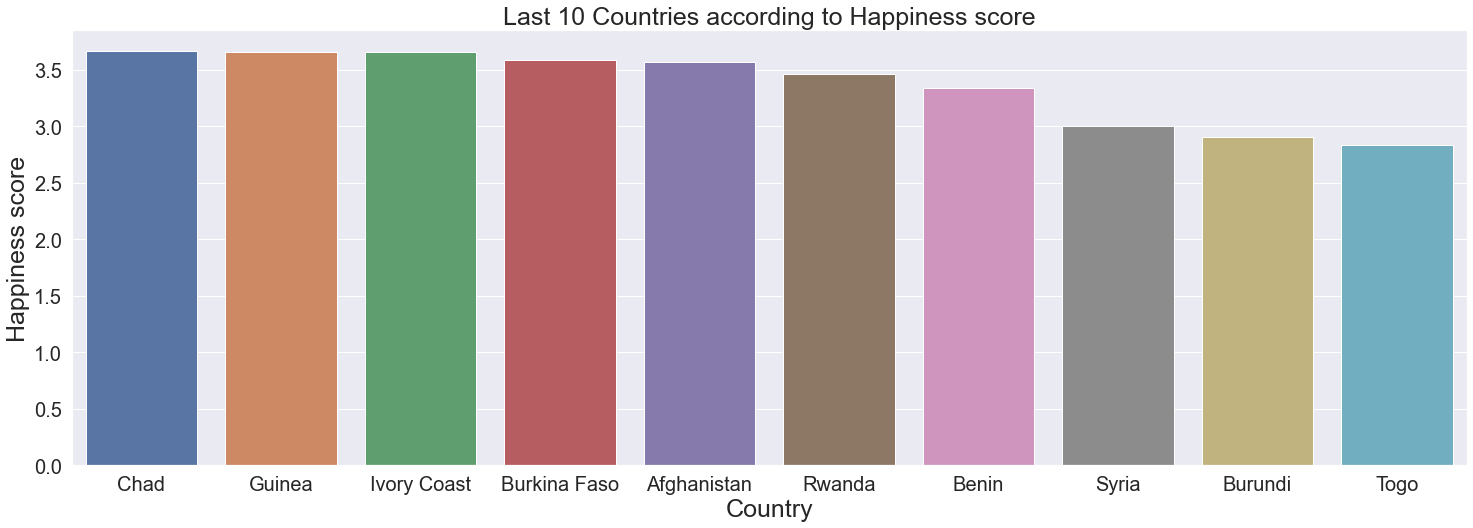

In [13]:
plt.figure(figsize = (25,8))
sb.barplot(x = last_10_country.index, y = last_10_country)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Happiness score', fontsize =  25)
plt.xlabel('Country' , fontsize = 25)
plt.title('Last 10 Countries according to Happiness score', fontsize = 25 )
plt.show()

#### Data-preprocessing for better visualization of Happiness score in Geopandas plot.

In [14]:
ds.Region.value_counts()

Sub-Saharan Africa                 40
Central and Eastern Europe         29
Latin America and Caribbean        22
Western Europe                     21
Middle East and Northern Africa    20
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
Australia and New Zealand           2
North America                       2
Name: Region, dtype: int64

In [15]:
world_map_df = gp.read_file(r"C:\Users\91743\World_Countries_shp_file\World_Countries.shp")

In [16]:
world_map_df

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"POLYGON ((34.21807 9.96458, 34.20722 9.90500, ..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.30010, 124.40446 ..."
250,Curacao (Netherlands),"POLYGON ((-68.96556 12.19889, -68.91196 12.181..."


In [17]:
df = ds.copy()

In [18]:
# changing some country name to match that in shp file.
df.Country.replace('North Cyprus','Cyprus', inplace = True)
df.Country.replace('Congo (Kinshasa)','Congo', inplace = True)
df.Country.replace('Congo (Brazzaville)','Congo', inplace = True)
df = df[~df.Country.duplicated(keep='first')]
df.Country.replace('Palestinian Territories','Palestine', inplace = True)
df.Country.replace('Somaliland region','Somalia', inplace = True)

In [19]:
# adding some extra countries for plotting that are not found in our data-set.
df = df.append(pd.Series({'Country':'Namibia', 'Happiness Score':4.57}), ignore_index = True)
df = df.append(pd.Series({'Country':'South Sudan', 'Happiness Score':2.82}), ignore_index = True)
df = df.append(pd.Series({'Country':'Democratic Republic of the Congo', 'Happiness Score': 4.42}), ignore_index = True)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1.0,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2.0,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3.0,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4.0,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5.0,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
...,...,...,...,...,...,...,...,...,...,...,...,...
154,Burundi,Sub-Saharan Africa,157.0,2.905,0.08658,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302
155,Togo,Sub-Saharan Africa,158.0,2.839,0.06727,0.20868,0.13995,0.28443,0.36453,0.10731,0.16681,1.56726
156,Namibia,NaN,NaN,4.570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,South Sudan,NaN,NaN,2.820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.fillna(0 , inplace = True)
df.fillna( 0 , inplace = True)

In [21]:
geo_data = pd.merge( world_map_df, df.loc[:,['Country','Happiness Score']] , 
                    left_on = 'COUNTRY', right_on = 'Country', how = 'inner')

In [22]:
geo_data.set_index('Country', inplace = True)

In [23]:
geo_data.loc['South Sudan','geometry'] = world_map_df.geometry[world_map_df.COUNTRY == 'South Sudan'].values[0]

In [24]:
geo_data.to_crs(epsg = 3857, inplace = True) # changing projection of geodata.

No handles with labels found to put in legend.


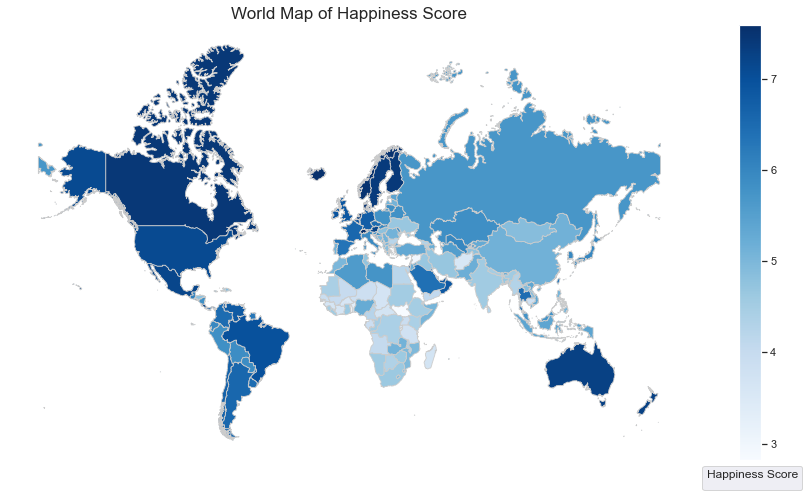

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_title('World Map of Happiness Score', fontsize = 17)
geo_data.plot(column = 'Happiness Score', cmap = 'Blues', 
           linewidth =0.8, 
           edgecolor = '0.8',
           ax = ax,
           legend = True, aspect = 1)
plt.legend(title = 'Happiness Score', bbox_to_anchor=(1.17, 0))
fig.set_size_inches(17,8)
plt.show()

Here we see most regions containing South and North America, North-West part of europe and Australia and New Zeland have good a comparitively better Happiness Score from rest part of the World.  
Also, we see most part of Asian and African countries needs further improvements in their Happiness Score.

### Prediction of Happiness-score

In [26]:
# cube-root transforming skew numeric data
for col in ds.columns[4:]:
    if abs( ds[col].skew()) > 0.5:
        ds[col] = (ds[col])**(1/3)

In [27]:
# label encoding 'region' column
ds['Region'] = LabelEncoder().fit_transform(ds['Region'])

In [29]:
# Minmaxscaling numeric categories:
for col in ds.columns[4:]:
    ds[col] = MinMaxScaler().fit_transform(ds[col].values.reshape(-1,1))

In [31]:
selected_features = ['Region','Standard Error','Economy (GDP per Capita)','Family',
    'Health (Life Expectancy)','Freedom','Trust (Government Corruption)',
   'Generosity','Dystopia Residual']

x_train, x_test, y_train, y_test = train_test_split(ds[selected_features], ds['Happiness Score'],
                                                   test_size = 0.2, random_state = 42)

In [32]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((126, 9), (32, 9), (126,), (32,))

In [41]:
x_train

,Region,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
137,8,0.471030,0.154246,0.903809,0.585544,0.580189,0.607141,0.618142,0.447326
55,1,0.291097,0.678666,0.964326,0.893480,0.318666,0.265336,0.321347,0.646975
126,1,0.390789,0.454449,0.821399,0.892917,0.296343,0.413427,0.462132,0.436879
84,8,0.587588,0.278262,0.867716,0.663330,0.729055,0.609036,0.626714,0.704346
154,8,0.268929,0.169573,0.631933,0.677692,0.723426,0.525519,0.612187,0.398557
...,...,...,...,...,...,...,...,...,...
71,2,0.419324,0.819938,0.910430,0.996093,0.890030,0.876184,0.791594,0.099497
106,4,0.260804,0.521249,0.755339,0.896180,0.392218,0.486576,0.432325,0.548663
14,5,0.290630,0.824949,0.961675,0.943751,0.815314,0.660316,0.795763,0.666409
92,1,0.450251,0.543362,0.894120,0.895175,0.499560,0.458710,0.654940,0.430953


#### Base Model Evaluation

model: RandomForestRegressor()
CV score:0.8943026598129731
score_std: 0.0378556825428192
----------
model: LinearRegression()
CV score:0.9622874214222991
score_std: 0.06932947597643604
----------
model: SVR()
CV score:0.46482518215453217
score_std: 0.1074553993608781
----------
model: AdaBoostRegressor()
CV score:0.8534747976839341
score_std: 0.04935351580981236
----------
model: GradientBoostingRegressor()
CV score:0.9213860792352815
score_std: 0.036110148638495
----------
model: KNeighborsRegressor()
CV score:0.7162394724469323
score_std: 0.08457512119061389
----------
model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_pa

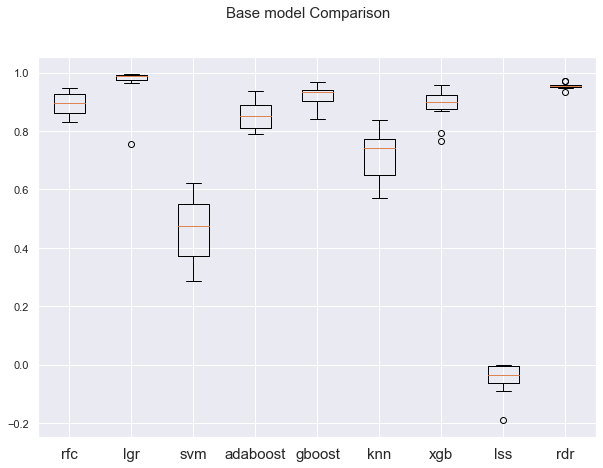

In [33]:
rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression()
adaboost =  AdaBoostRegressor()
gboost = GradientBoostingRegressor()
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor(silent = True, verbose = 0)
lss = Lasso()
rdr = Ridge()


models = [rfr, lr, svr, adaboost, gboost, knn, xgb, lss,rdr]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 15)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfc', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','lss','rdr'],
                  fontsize = 15)
fig.set_size_inches(10,7)
plt.show() 

Here, we choose lr, gboost, xgb and rdr model for further tuning because these models show better performance interms of higher mean and median score and less std of scores. 

#### Hyper-parameter tuning

In [34]:
param_gboost =  dict(
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
    max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
    n_estimators = [100, 150, 200],
    min_samples_split = [1,2,3])
  
param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ],
     alpha = [0.1,0.5,0.75,1,2])

param_rdr = dict(alpha = np.arange(0.05,2, 0.05), solver = ['svd', 
         'cholesky','lsqr','sparse_cg','sag','saga'])

In [35]:
model_param_list = [(gboost,param_gboost), (xgb,param_xgb), (rdr,param_rdr)]

In [36]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_rearch = RandomizedSearchCV(model, param, cv = 10, n_jobs = -1, scoring = 'r2',
                                  random_state = 42)
    r_rearch.fit(x_train, y_train.values.ravel())
    best_cvscore = r_rearch.best_score_
    best_param = r_rearch.best_params_
    best_estimator = r_rearch.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
print('best_estimators:',best_estimator_list)

model: GradientBoostingRegressor()
best_cvscore: 0.9187889946120398
best_param: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.1}


[21:38:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
 

#### Testing

In [37]:
# testing for train data
best_estimator_list.append(lr) # appending liner reg model to the list for testing.

for model in best_estimator_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy %:',  round(score*100,3))
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('\n')


model GradientBoostingRegressor()
accuracy %: 99.931
root_mean_squared_error: 0.029639462718812324


[21:38:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


model XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, si

In [38]:
for model in best_estimator_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy %:',  round(score*100,3))
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('\n')

model GradientBoostingRegressor()
accuracy %: 96.376
root_mean_squared_error: 0.22675087071540515


[21:38:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


model XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, sil

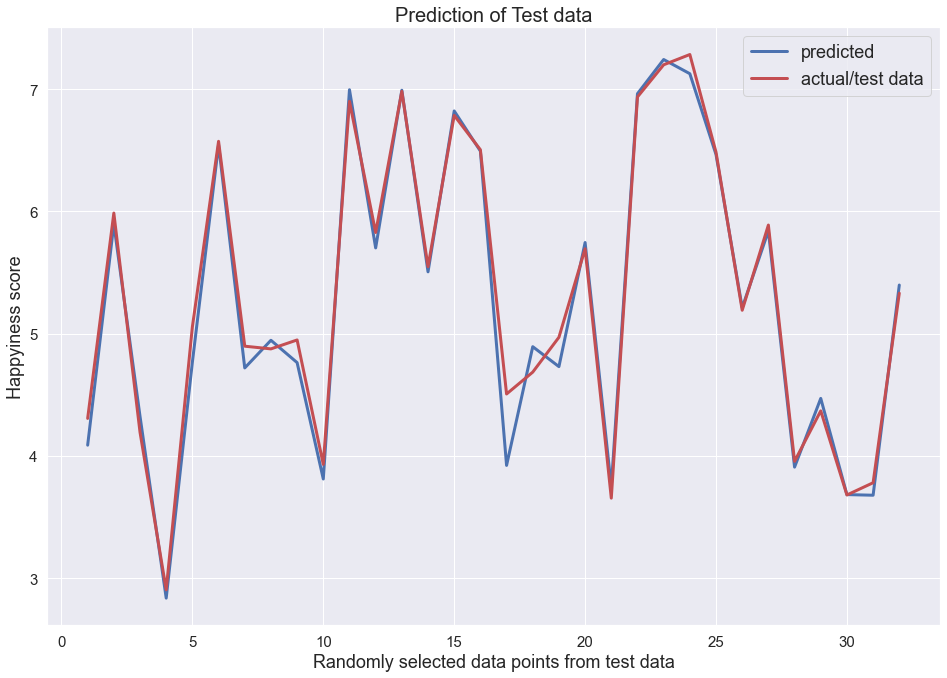

In [39]:
fig = plt.figure(figsize = (16,11))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,33,1),y_pred, 'b-', linewidth = 3)
ax.plot(np.arange(1,33,1), y_test, 'r-', linewidth = 3)
plt.legend(['predicted','actual/test data'],prop={'size': 18})
plt.xticks( fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Randomly selected data points from test data', fontsize= 18)
plt.ylabel('Happyiness score', fontsize= 18)
plt.title('Prediction of Test data', fontsize= 20)
plt.show()

Here, we see that simple linear regression model performs better on both train and test data, and also generalizes well on unseen/test  data, so we shall choose it as our model for this project.

#### Saving best model as Liner Regression

In [40]:
import joblib

joblib.dump(lr, 'lr_happiness_pred.obj')
print('Model successfully saved.')

Model successfully saved.
